# COVID-19
캐글 [Tarun Kumar](https://www.kaggle.com/tarunkr)의   
코로나19 커널[COVID-19 Case Study - Analysis, Viz & Comparisons](https://www.kaggle.com/tarunkr/covid-19-case-study-analysis-viz-comparisons#Global-Prediction) 필사 하였습니다.


## Library
- Pandas : 데이터 핸들링  
- Numpy : 선형대수 및 계산  
- Matplotlib : 시각화 도구   
- pycountry_convert : 대륙 이름 라이브러리  
- folium : 지도 시각화 도구  
- keras : 예측 모델  
- plotly : 상호작용 시각화 도구


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker 
import pycountry_convert as pc
import folium
import branca
from datetime import datetime, timedelta,date
from scipy.interpolate import make_interp_spline, BSpline
import plotly.express as px
import json, requests
import calmap

from tensorflow.keras.layers import Input, Dense, Activation, LeakyReLU
from tensorflow.keras import models
from tensorflow.keras.optimizers import RMSprop, Adam

import warnings
warnings.filterwarnings('ignore')

## Imports Datasets
`github`에서 데이터 가져오기

In [0]:
df_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
df_covid19 = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv")
df_table = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_time.csv", parse_dates = ['Last_Update'])

In [0]:
df_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8


In [0]:
cond = df_confirmed['Country/Region'].str.contains('^\w{2}$|\,|\*|\(|\'|\-')
df_confirmed.loc[cond, 'Country/Region'].unique()

array(['Congo (Brazzaville)', 'Congo (Kinshasa)', "Cote d'Ivoire",
       'Korea, South', 'Taiwan*', 'US'], dtype=object)

In [0]:
df_deaths.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,4,4,4,4,4,4,4,6,6
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,2,2,2,2,2,4,5,5,6,8,10,10,11,15,15,16,17
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,3,4,4,4,7,9,11,15,17,17,19,21,25,26,29,31,35,44,58,86,105
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,3,3,3,6,8,12,14,15,16
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2


In [0]:
df_covid19.head()

,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active
0,Australia,2020-04-04 10:52:42,-25.0000,133.0000,5550,30,701,4819
1,Austria,2020-04-04 10:46:32,47.5162,14.5501,11781,186,2507,9088
2,Canada,2020-04-04 10:52:27,60.0010,-95.0010,12545,188,2321,0
3,China,2020-04-04 09:38:19,30.5928,114.3055,82543,3330,76942,2271
4,Denmark,2020-04-04 10:46:32,56.0000,10.0000,3948,139,1289,2520


In [0]:
df_table.head()

,Country_Region,Last_Update,Confirmed,Deaths,Recovered,Active,Delta_Confirmed,Delta_Recovered
0,Afghanistan,2020-01-22,0,0,NaN,NaN,0,NaN
1,Afghanistan,2020-01-23,0,0,NaN,NaN,0,NaN
2,Afghanistan,2020-01-24,0,0,NaN,NaN,0,NaN
3,Afghanistan,2020-01-25,0,0,NaN,NaN,0,NaN
4,Afghanistan,2020-01-26,0,0,NaN,NaN,0,NaN


## Preprocessing

In [0]:
df_confirmed = df_confirmed.rename(columns = {'Province/State' : 'state',
                                              'Country/Region' : 'country'})
df_deaths = df_deaths.rename(columns = {'Province/State' : 'state',
                                        'Country/Region': 'country'})
df_covid19 = df_covid19.rename(columns = {'Country_Region' : 'country'})
df_covid19['Active'] = df_covid19['Confirmed'] - df_covid19['Recovered'] - df_covid19['Deaths']

In [0]:
df_confirmed.loc[df_confirmed['country'] == 'US', 'country'] = 'USA'
df_deaths.loc[df_deaths['country'] == 'US', 'country'] = 'USA'
df_covid19.loc[df_covid19['country'] == 'US', 'country'] = 'USA'
df_table.loc[df_table['Country_Region'] == 'US', 'Country_Region'] = 'USA'

In [0]:
df_confirmed.loc[df_confirmed['country'] == 'Korea, South', 'country'] = 'South Korea'
df_deaths.loc[df_deaths['country'] == 'Korea, South', 'country'] = 'South Korea'
df_covid19.loc[df_covid19['country'] == 'Korea, South', 'country'] = 'South Korea'
df_table.loc[df_table['Country_Region'] == 'Korea, South', 'Country_Region'] = 'South Korea'

In [0]:
df_confirmed.loc[df_confirmed['country'] == 'Taiwan*', 'country'] = 'Taiwan'
df_deaths.loc[df_deaths['country'] == 'Taiwan*', 'country'] = 'Taiwan'
df_covid19.loc[df_covid19['country'] == 'Taiwan*', 'country'] = 'Taiwan'
df_table.loc[df_table['Country_Region'] == 'Taiwan*', 'Country_Region'] = 'Taiwan'

In [0]:
df_confirmed.loc[df_confirmed['country'] == 'Congo (Kinshasa)', 'country'] = 'Democratic Republic of the Congo'
df_deaths.loc[df_deaths['country'] == 'Congo (Kinshasa)', 'country'] = 'Democratic Republic of the Congo'
df_covid19.loc[df_covid19['country'] == 'Congo (Kinshasa)', 'country'] = 'Democratic Republic of the Congo'
df_table.loc[df_table['Country_Region'] == 'Congo (Kinshasa)', 'Country_Region'] = 'Democratic Republic of the Congo'

In [0]:
df_confirmed.loc[df_confirmed['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_deaths.loc[df_deaths['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_covid19.loc[df_covid19['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_table.loc[df_table['Country_Region'] == "Cote d'Ivoire", "Country_Region"] = "Côte d'Ivoire"

In [0]:
df_confirmed.loc[df_confirmed['country'] == 'Reunion', 'country'] = 'Réunion'
df_deaths.loc[df_deaths['country'] == 'Reunion', 'country'] = 'Réunion'
df_covid19.loc[df_covid19['country'] == 'Reunion', 'country'] = 'Réunion'
df_table.loc[df_table['Country_Region'] == 'Reunion', 'Country_Region'] = 'Réunion'

In [0]:
df_confirmed.loc[df_confirmed['country'] == 'Congo (Brazzaville)', 'country'] = 'Republic of the Congo'
df_deaths.loc[df_deaths['country'] == 'Congo (Brazzaville)', 'country'] = 'Republic of the Congo'
df_covid19.loc[df_covid19['country'] == 'Congo (Brazzaville)', 'country'] = 'Republic of the Congo'
df_table.loc[df_table['Country_Region'] == 'Congo (Brazzaville)', 'Country_Region'] = 'Republic of the Congo'

In [0]:
df_confirmed.loc[df_confirmed['country'] == 'Bahamas, The', 'country'] = 'Bahamas'
df_deaths.loc[df_deaths['country'] == 'Bahamas, The', 'country'] = 'Bahamas'
df_covid19.loc[df_covid19['country'] == 'Bahamas, The', 'country'] = 'Bahamas'
df_table.loc[df_table['Country_Region'] == 'Bahamas, The', 'Country_Region'] = 'Bahamas'

In [0]:
df_confirmed.loc[df_confirmed['country'] == 'Gambia, The', 'country'] = 'Gambia'
df_deaths.loc[df_deaths['country'] == 'Gambia, The', 'country'] = 'Gambia'
df_covid19.loc[df_covid19['country'] == 'Gambia, The', 'country'] = 'Gambia'
df_table.loc[df_table['Country_Region'] == 'Gambia', 'Country_Region'] = 'Gambia'

In [0]:
countries = np.asarray(df_confirmed['country'])
countries1 = np.asarray(df_covid19['country'])

continents = {
    'NA' : 'North America',
    'SA' : 'South America', 
    'AS' : 'Asia',
    'OC' : 'Australia',
    'AF' : 'Africa',
    'EU' : 'Europe',
    'na' : 'Others'
}

In [0]:
def country_to_continent_code(country):
    try:
        return pc.country_alpha2_to_continent_code(pc.country_name_to_country_alpha2(country))
    except :
        return 'na'

df_confirmed.insert(2, 'continent', [continents[country_to_continent_code(country)] for country in countries[:]])
df_deaths.insert(2, 'continent',  [continents[country_to_continent_code(country)] for country in countries[:]])
df_covid19.insert(1, 'continent',  [continents[country_to_continent_code(country)] for country in countries1[:]])
df_table.insert(1, 'continent',  [continents[country_to_continent_code(country)] for country in df_table['Country_Region'].values])

In [0]:
df_table = df_table[df_table["continent"] != "Others"]

In [0]:
df_deaths[df_deaths["continent"] == 'Others']

,state,country,continent,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20
88,NaN,Diamond Princess,Others,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,3,3,3,4,4,6,6,6,6,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,7,7,8,8,8,10,10,10,10,10,10,10,10,11,11,11
127,NaN,Holy See,Others,41.902900,12.453400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
236,NaN,Timor-Leste,Others,-8.874217,125.727539,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
241,NaN,West Bank and Gaza,Others,31.952200,35.233200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1
247,NaN,Kosovo,Others,42.602636,20.902977,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1
248,NaN,Burma,Others,21.916200,95.956000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1
252,NaN,MS Zaandam,Others,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2


In [0]:
df_confirmed = df_confirmed.replace(np.nan, '', regex = True)
df_deaths = df_deaths.replace(np.nan, '', regex = True)

In [0]:
def plot_params(ax,axis_label = None,
                plt_title = None,
                label_size = 15,
                axis_fsize = 15,
                title_fsize = 20,
                scale = 'linear'):
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.tick_params(which = 'both', width = 1,labelsize = label_size)
    ax.tick_params(which = 'major', length = 6)
    ax.tick_params(which = 'minor', length = 3, color = '0.8')
    
    plt.grid(lw = 1, ls = '-', c = '0.7', which = 'major')
    plt.grid(lw = 1, ls = '-', c = '0.9', which = 'minor')

    plt.title( plt_title,{'fontsize' : title_fsize})
    
    plt.yscale(scale)
    plt.minorticks_on()

    xl = plt.xlabel(axis_label[0], fontsize = axis_fsize)
    yl = plt.ylabel(axis_label[1], fontsize = axis_fsize)

In [0]:
def visualize_covid_cases(confirmed,
                          deaths,
                          continent = None,
                          country = None,
                          state = None,
                          period = None,
                          figure = None,
                          scale = 'linear'):
    x = 0
    if figure == None:
        f = plt.figure(figsize = (10, 10))
        ax = f.add_subplot(111)
    else :
        f = figure[0]
        ax = f.add_subplot(figure[1], figure[2], figure[3])
    ax.set_axisbelow(True)
    plt.tight_layout(pad = 10, w_pad = 5, h_pad = 5)
    
    stats = [confirmed, deaths]
    label = ['Confirmed', 'Deaths']
    
    if continent != None:
        params = ['continent', continent]
    elif country != None:
        params = ['country', country]
    else: 
        params = ['All', 'All']
    color = ['darkcyan', 'crimson']
    marker_style = dict(linewidth=3,
                        linestyle = '-',
                        marker = 'o',
                        markersize = 4,
                        markerfacecolor = '#ffffff')
    for i, stat in enumerate(stats):
        if params[1] == 'All':
            cases = np.sum(np.asarray(stat.iloc[:,5:]), axis = 0)[x:]
        else :
            cases = np.sum(np.asarray(stat[stat[params[0]] == params[1]].iloc[:,5:]), axis = 0)[x:]
        date = np.arange(1, cases.shape[0]+1)[x:]
        plt.plot(date, cases,
                 label = label[i] + ' (Total : '+str(cases[-1]) + ')',
                 color = color[i],
                 **marker_style)
        plt.fill_between(date, cases,
                         color = color[i],
                         alpha = 0.3)

    if params[1] == 'All':
        Total_confirmed = np.sum(np.asarray(stats[0].iloc[:,5:]),axis = 0)[x:]
        Total_deaths = np.sum(np.asarray(stats[1].iloc[:,5:]),axis = 0)[x:]
    else :
        Total_confirmed =  np.sum(np.asarray(stats[0][stat[params[0]] == params[1]].iloc[:,5:]), axis = 0)[x:]
        Total_deaths = np.sum(np.asarray(stats[1][stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        
    text = 'From ' + stats[0].columns[5] + ' to ' + stats[0].columns[-1] + '\n'
    text += 'Mortality rate : ' + str(int(Total_deaths[-1]/(Total_confirmed[-1]) * 10000) / 100) + '\n'
    text += 'Last 5 Days:\n'
    text += 'Confirmed : ' + str(Total_confirmed[-1] - Total_confirmed[-6]) + '\n'
    text += 'Deaths : ' + str(Total_deaths[-1] - Total_deaths[-6]) + '\n'
    text += 'Last 24 Hours:\n'
    text += 'Confirmed : ' + str(Total_confirmed[-1] - Total_confirmed[-2]) + '\n'
    text += 'Deaths : ' + str(Total_deaths[-1] - Total_deaths[-2]) + '\n'
    
    plt.text(0.02, 0.78, text,
             fontsize = 15,
             horizontalalignment = 'left',
             verticalalignment = 'top',
             transform = ax.transAxes,bbox = dict(facecolor = 'white', alpha = 0.4))
    
    axis_label = ['Days (' + df_confirmed.columns[5] + ' - ' + df_confirmed.columns[-1] + ')', 'No of Cases']

    plot_params(ax,axis_label,scale = scale)
    
    if params[1] == 'All' :
        plt.title('COVID-19 Cases World', {'fontsize' : 25})
    else:   
        plt.title('COVID-19 Cases for ' + params[1], {'fontsize' : 25})
        
    l = plt.legend(loc= 'best',fontsize = 15)
    
    if figure == None:
        plt.show()

In [0]:
def get_total_cases(cases, country = 'All'):
    if(country == 'All') :
        return np.sum(np.asarray(cases.iloc[:,5:]),axis = 0)[-1]
    else :
        return np.sum(np.asarray(cases[cases['country'] == country].iloc[:,5:]),axis = 0)[-1]
    
def get_mortality_rate(confirmed,deaths, continent = None, country = None):
    if continent != None:
        params = ['continent', continent]
    elif country != None:
        params = ['country', country]
    else :
        params = ['All', 'All']
    
    if params[1] == 'All' :
        Total_confirmed = np.sum(np.asarray(confirmed.iloc[:,5:]),axis = 0)
        Total_deaths = np.sum(np.asarray(deaths.iloc[:,5:]),axis = 0)
        mortality_rate = np.round((Total_deaths/(Total_confirmed + 1.01)) * 100,2)
    else :
        Total_confirmed =  np.sum(np.asarray(confirmed[confirmed[params[0]] == params[1]].iloc[:, 5:]),axis = 0)
        Total_deaths = np.sum(np.asarray(deaths[deaths[params[0]] == params[1]].iloc[:,5:]),axis = 0)
        mortality_rate = np.round((Total_deaths/(Total_confirmed + 1.01)) * 100,2)
    
    return np.nan_to_num(mortality_rate)
def dd(date1,date2):
    return (datetime.strptime(date1,'%m/%d/%y') - datetime.strptime(date2,'%m/%d/%y')).days


out = ''

## General Analysis of Data

In [0]:
df_countries_cases = df_covid19.copy().drop(['Lat','Long_','continent','Last_Update'],axis = 1)
df_countries_cases.index = df_countries_cases['country']
df_countries_cases = df_countries_cases.drop(['country'],axis = 1)

df_continents_cases = df_covid19.copy().drop(['Lat','Long_','country','Last_Update'],axis = 1)
df_continents_cases = df_continents_cases.groupby(['continent']).sum()

In [0]:
df_t = pd.DataFrame(pd.to_numeric(df_countries_cases.sum()),dtype = np.float64).transpose()
df_t['Mortality Rate (per 100)'] = np.round(100 * df_t['Deaths']/df_t['Confirmed'], 2)
df_t.style.background_gradient(cmap = 'Wistia', axis = 1).format('{:.0f}', subset = ['Confirmed'])

,Confirmed,Deaths,Recovered,Active,Mortality Rate (per 100)
0,1131713,59884.000000,233591.000000,838238.000000,5.290000


In [0]:
df_continents_cases['Mortality Rate (per 100)'] = np.round(100 * df_continents_cases['Deaths']/df_continents_cases['Confirmed'], 2)
df_continents_cases.style.background_gradient(cmap = 'Blues', subset=['Confirmed'])\
                         .background_gradient(cmap = 'Reds', subset=['Deaths'])\
                         .background_gradient(cmap = 'Greens', subset=['Recovered'])\
                         .background_gradient(cmap = 'Purples', subset=['Active'])\
                         .background_gradient(cmap = 'YlOrBr', subset=['Mortality Rate (per 100)'])

,Confirmed,Deaths,Recovered,Active,Mortality Rate (per 100)
continent,,,,,
Africa,8000,336,704,6960,4.200000
Asia,209111,8219,108784,92108,3.930000
Australia,6513,31,828,5654,0.480000
Europe,588434,43037,108068,437329,7.310000
North America,297232,7556,12929,276747,2.540000
Others,1080,16,650,414,1.480000
South America,21343,689,1628,19026,3.230000


In [0]:
df_countries_cases['Mortality Rate (per 100)'] = np.round(100 * df_countries_cases['Deaths']/df_countries_cases['Confirmed'], 2)
df_countries_cases.sort_values('Confirmed', ascending = False)\
                  .style.background_gradient(cmap = 'Blues', subset = ['Confirmed'])\
                        .background_gradient(cmap = 'Reds', subset = ['Deaths'])\
                        .background_gradient(cmap = 'Greens', subset = ['Recovered'])\
                        .background_gradient(cmap = 'Purples', subset = ['Active'])\
                        .background_gradient(cmap = 'YlOrBr', subset = ['Mortality Rate (per 100)'])

,Confirmed,Deaths,Recovered,Active,Mortality Rate (per 100)
country,,,,,
USA,278458,7159,9897,261402,2.570000
Spain,124736,11744,34219,78773,9.420000
Italy,119827,14681,19758,85388,12.250000
Germany,91159,1275,24575,65309,1.400000
France,83029,6520,14135,62374,7.850000
China,82543,3330,76942,2271,4.030000
Iran,55743,3452,19736,32555,6.190000
United Kingdom,38697,3611,209,34877,9.330000
Turkey,20921,425,484,20012,2.030000


### Top 10 countries (Confirmed Cases and Deaths)

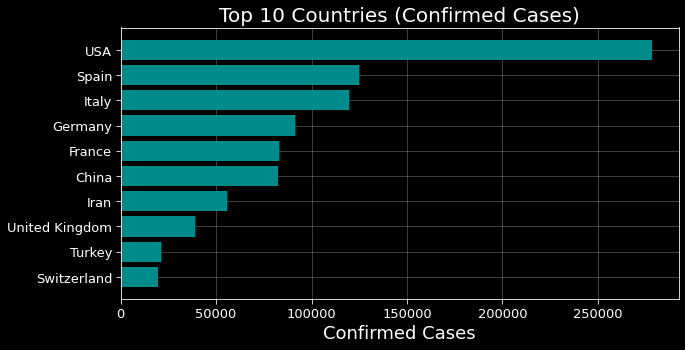

In [0]:
f = plt.figure(figsize = (10, 5))
f.add_subplot(111)

plt.axes(axisbelow = True)
plt.barh(df_countries_cases.sort_values('Confirmed')['Confirmed'].index[-10:],
         df_countries_cases.sort_values('Confirmed')['Confirmed'].values[-10:],
         color = 'darkcyan')
plt.tick_params(size = 5, labelsize = 13)
plt.xlabel('Confirmed Cases', fontsize = 18)
plt.title('Top 10 Countries (Confirmed Cases)', fontsize = 20)
plt.grid(alpha = 0.3)

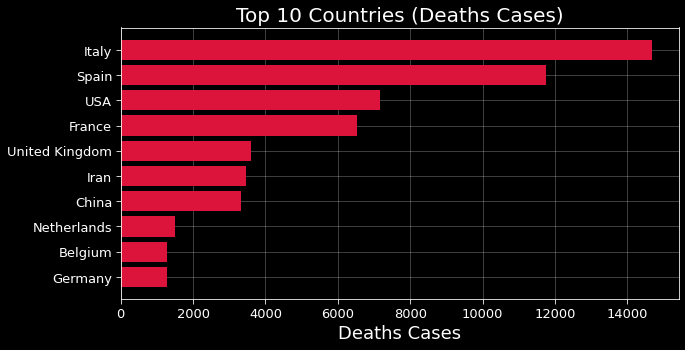

In [0]:
f = plt.figure(figsize = (10, 5))
f.add_subplot(111)

plt.axes(axisbelow = True)
plt.barh(df_countries_cases.sort_values('Deaths')['Deaths'].index[-10:],
         df_countries_cases.sort_values('Deaths')['Deaths'].values[-10:],
         color = 'crimson')
plt.tick_params(size = 5, labelsize = 13)
plt.xlabel('Deaths Cases', fontsize = 18)
plt.title('Top 10 Countries (Deaths Cases)', fontsize = 20)
plt.grid(alpha = 0.3, which = 'both')

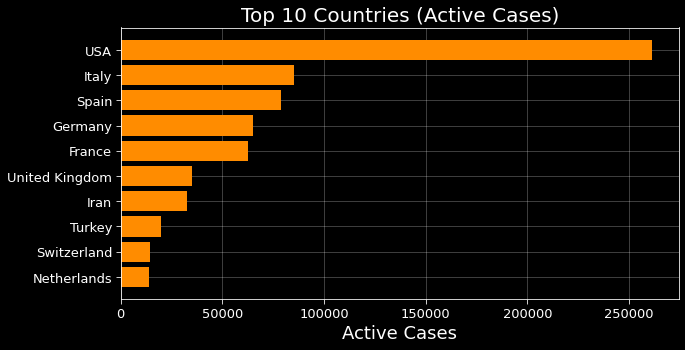

In [0]:
f = plt.figure(figsize = (10, 5))
f.add_subplot(111)

plt.axes(axisbelow = True)
plt.barh(df_countries_cases.sort_values('Active')['Active'].index[-10:],
         df_countries_cases.sort_values('Active')['Active'].values[-10:],
         color = 'darkorange')
plt.tick_params(size = 5, labelsize = 13)
plt.xlabel('Active Cases', fontsize = 18)
plt.title('Top 10 Countries (Active Cases)', fontsize = 20)
plt.grid(alpha = 0.3, which = 'both')

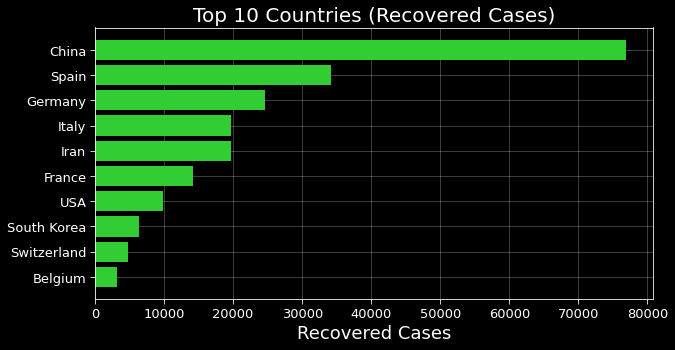

In [0]:
f = plt.figure(figsize = (10, 5))
f.add_subplot(111)

plt.axes(axisbelow = True)
plt.barh(df_countries_cases.sort_values('Recovered')['Recovered'].index[-10:],
         df_countries_cases.sort_values('Recovered')['Recovered'].values[-10:],
         color = 'limegreen')
plt.tick_params(size = 5, labelsize = 13)
plt.xlabel('Recovered Cases', fontsize = 18)
plt.title('Top 10 Countries (Recovered Cases)', fontsize = 20)
plt.grid(alpha = 0.3, which = 'both')

## Correlation Analysis

In [0]:
df_countries_cases.iloc[:,:-1].corr().style.background_gradient(cmap = 'Reds')

,Confirmed,Deaths,Recovered,Active
Confirmed,1.000000,0.794510,0.574788,0.964017
Deaths,0.794510,1.000000,0.570444,0.704194
Recovered,0.574788,0.570444,1.000000,0.339393
Active,0.964017,0.704194,0.339393,1.000000


In [0]:
df_continents_cases.iloc[:,:-1].corr().style.background_gradient(cmap = 'Reds')

,Confirmed,Deaths,Recovered,Active
Confirmed,1.000000,0.942502,0.765088,0.979711
Deaths,0.942502,1.000000,0.755619,0.902840
Recovered,0.765088,0.755619,1.000000,0.621974
Active,0.979711,0.902840,0.621974,1.000000


In [0]:
world_map = folium.Map(location = [10, 0],
                       tiles = "cartodbpositron",
                       zoom_start = 2,
                       max_zoom = 6,
                       min_zoom = 2)

for i in range(0,len(df_confirmed)):
    folium.Circle(
        location = [df_confirmed.iloc[i]['Lat'], df_confirmed.iloc[i]['Long']],
        tooltip = "<h5 style='text-align:center;font-weight: bold'>" + df_confirmed.iloc[i]['country'] + "</h5>" +
                    "<div style='text-align:center;'>" + str(np.nan_to_num(df_confirmed.iloc[i]['state'])) + "</div>" +
                    "<hr style='margin:10px;'>" +
                    "<ul style='color: #444;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>" +
        "<li>Confirmed: " + str(df_confirmed.iloc[i,-1]) + "</li>" +
        "<li>Deaths:   " + str(df_deaths.iloc[i,-1]) + "</li>" +
        "<li>Mortality Rate:   " + str(np.round(df_deaths.iloc[i,-1]/(df_confirmed.iloc[i,-1] + 1.00001) * 100,2)) + "</li>" +
        "</ul>"
        ,
        radius = (int((np.log(df_confirmed.iloc[i,-1] + 1.00001))) + 0.2) * 50000,
        color = '#ff6600',
        fill_color = '#ff8533',
        fill = True).add_to(world_map)
world_map

## Reference
- [COVID-19 Case Study - Analysis, Viz & Comparisons](https://www.kaggle.com/tarunkr/covid-19-case-study-analysis-viz-comparisons)
- [tarunk04/COVID-19-CaseStudy-and-Predictions](https://github.com/tarunk04/COVID-19-CaseStudy-and-Predictions)